In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib
import imgaug.augmenters as iaa
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# import segmentation_models as sm
# from segmentation_models.metrics import iou_score as sm_iou
from keras_unet.models import custom_unet
from keras_unet.metrics import iou
from keras_unet.losses import jaccard_distance
from skimage import morphology
from lovasz_losses_tf import lovasz_hinge 

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


# Data preparation

In [2]:
images = list(Path(os.path.join('../data/unet/lung_segmentation/CXR_png/img')).glob('**/*'))
masks = list(Path(os.path.join('../data/unet/lung_segmentation/masks/img')).glob('**/*'))

In [3]:
print("Amount of images: ", len(images))
print("Amount of masks: ", len(masks))

Amount of images:  800
Amount of masks:  704


In [4]:
img_mask_tuples = []

for mask_path in masks:
    for i in images:
        basename = (os.path.basename(i)).split(".")[0]
        if basename in str(mask_path):
            img_path = i
            break
    img_mask_tuples.append((str(img_path), str(mask_path)))

In [5]:
len(img_mask_tuples)

704

## Plot images and masks

In [6]:
def plot_img(img_mask_tuple):
    img_concat = np.concatenate((cv2.imread(str(img_mask_tuple[0])), cv2.imread(str(img_mask_tuple[1]))), axis=1)
    plt.axis('off')
    plt.imshow(img_concat)

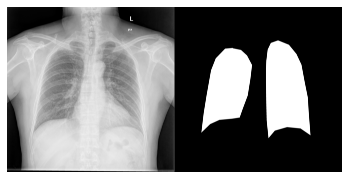

In [7]:
plot_img(img_mask_tuples[1])

In [8]:
def plot_img_matrix(img_mask_tuple_list, cols):
    # concat
    images = []
    for t in img_mask_tuple_list:
        img_concat = np.concatenate((cv2.imread(str(t[0])), cv2.imread(str(t[1]))), axis=1)
        images.append(img_concat)
    # plot
    plt.subplots(figsize=(15,5))
    if len(images) % cols == 0:
        rows = len(images) / cols
    else:
        rows = (len(images) % cols) +1
    for num, x in enumerate(images):
        plt.subplot(rows,cols,num+1)
        plt.axis('off')
        plt.imshow(x)

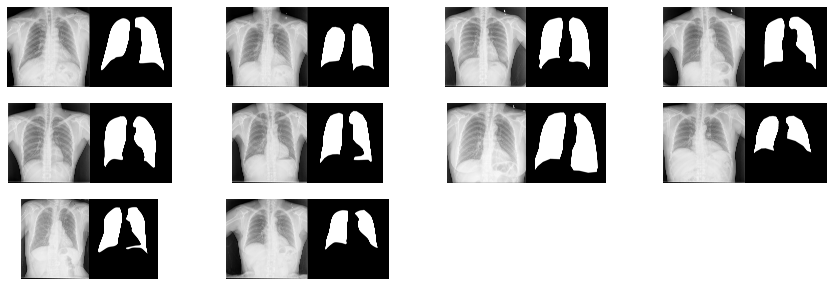

In [9]:
plot_img_matrix(img_mask_tuples[:10], 4)

In [10]:
df = pd.DataFrame(img_mask_tuples, dtype='str', columns=['img', 'mask'])
df_train = df.sample(frac=0.9, random_state=200)
df_val = df.drop(df_train.index)

df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)

In [11]:
print(len(df_train))
print(len(df_val))

634
70


## UNET

In [12]:
IMG_SIZE = 256
BATCH_SIZE = 8

In [13]:
# https://github.com/aleju/imgaug/issues/66#issuecomment-387609992
# ToDo: Fine-tune params, especially gain. cutoff should remain close to 1, 5 <= gain < 20 
aug_clahe = iaa.AllChannelsCLAHE(clip_limit=(4), tile_grid_size_px=(2,2), per_channel=True)

In [14]:
def applySigmoidContrast(img):
    img = sigm_aug.augment_image(img)
    return img

In [15]:
def binarize_mask(img):
    # specify a threshold 0-255
    threshold = 255 // 2
    # make all pixels < threshold black
    return 1.0 * (img > threshold)

In [16]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq_img = iaa.Sequential([
    iaa.Fliplr(0.5),
    sometimes(iaa.Affine(
            rotate=(-10, 10),
            shear=(10,10),
            scale={"x": (1, 1.1), "y": (1, 1.1)},
    )),
], random_order=True)


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=BATCH_SIZE, shuffle=True, augment=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X_img, X_mask = self.__get_data(batch)
        return np.array(X_img), np.array(X_mask)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)    

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        
        X_imgs = []
        X_masks = []

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]])), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Apply CLAHE
            # img = aug_clahe(image=img)

            mask = cv2.resize(cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE) ,interpolation=cv2.INTER_NEAREST)
            mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)[1]

            # normalize / rescale
            img = img / 255.0
            mask = mask / 255.0

            if (self.augment):
                seq_img_i = seq_img.to_deterministic()
                img = seq_img_i.augment_image(img)
                mask = seq_img_i.augment_image(mask)

            X_imgs.append(img)
            X_masks.append(mask)

        return X_imgs, X_masks

In [17]:
train_generator = DataGenerator(df_train, augment=False)
val_generator = DataGenerator(df_val, augment=False)

In [18]:
example = train_generator.__getitem__(0)

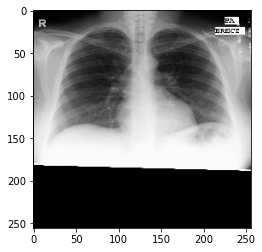

In [19]:
plt.imshow(example[0][-1,:,:])

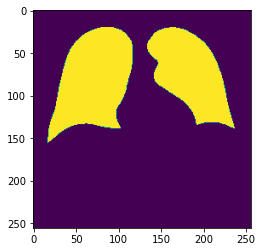

In [20]:
plt.imshow(example[1][-1,:,:])

In [21]:
import tensorflow.keras.backend as K

def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coeff(y_true, y_pred)

def dice_be(y_true, y_pred):
    dl = dice_loss(y_true, y_pred)
    bce = K.binary_crossentropy(y_true, y_pred)
    return 2.0 * dl + 1.0 * bce

In [22]:
model = custom_unet(
    input_shape=(256, 256, 3),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=2e-4),
    # loss=dice_loss,
    loss='binary_crossentropy',
    # loss=dice_coef_loss,
    metrics=['binary_accuracy', iou]
)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       spatial_dropout2d[0][0]          
_______________________________________________________________________________________

In [23]:
mcp_save = ModelCheckpoint('../models/unet_1209.h5', save_best_only=True, monitor='val_iou', mode='max')
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, verbose=1)

In [24]:
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    epochs=20,
                    callbacks=[mcp_save, reduceLROnPlat])

Epoch 1/20
79/79 [==============================] - 102s 1s/step - loss: 0.3676 - binary_accuracy: 0.7971 - iou: 0.5273 - val_loss: 0.1258 - val_binary_accuracy: 0.9502 - val_iou: 0.8007
Epoch 2/20
79/79 [==============================] - 100s 1s/step - loss: 0.1154 - binary_accuracy: 0.9431 - iou: 0.7961 - val_loss: 0.0972 - val_binary_accuracy: 0.9562 - val_iou: 0.8139
Epoch 3/20
79/79 [==============================] - 101s 1s/step - loss: 0.0866 - binary_accuracy: 0.9548 - iou: 0.8284 - val_loss: 0.0884 - val_binary_accuracy: 0.9618 - val_iou: 0.8339
Epoch 4/20
79/79 [==============================] - 103s 1s/step - loss: 0.0699 - binary_accuracy: 0.9631 - iou: 0.8544 - val_loss: 0.0674 - val_binary_accuracy: 0.9712 - val_iou: 0.8638
Epoch 5/20
79/79 [==============================] - ETA: 0s - loss: 0.0668 - binary_accuracy: 0.9640 - iou: 0.8624
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
79/79 [==============================] - 102s 1s/step - l

In [6]:
model = tf.keras.models.load_model('../models/unet_0109_3.h5', compile=False)

In [7]:
def resize(img):
    img = cv2.resize(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [8]:
def get_pred_generator(img_list):
    df = pd.DataFrame(img_list, dtype='str', columns=['img'])
    return ImageDataGenerator().flow_from_dataframe(
        dataframe=df,
        x_col='img',
        directory=None,
        # target_size=(IMG_SIZE, IMG_SIZE),
        preprocess_function=resize,
        class_mode=None,
        # color_mode='grayscale',
        batch_size=8,
    )

In [9]:
def remove_small_regions(img):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    cleaned = morphology.remove_small_objects(img, min_size=64, connectivity=1)
    cleaned = morphology.remove_small_holes(img, area_threshold=64)
    return cleaned

In [10]:
def pred_and_save_masks(in_path, out_path):
    images = list(Path(os.path.join(in_path)).glob('**/*'))
    pred = model.predict(get_pred_generator(images), batch_size=8)

    # now save our pred as images
    for i in range(0,len(pred)):
        org_img = str(images[i])
        pred_mask_name = os.path.basename(org_img).rsplit('.')[0] + '_predmask.jpg'
        #mask = cv2.threshold(pred[i][:,:,0],127,255,cv2.THRESH_BINARY)[1]
        # mask = np.asarray(mask, dtype=int)
        #mask = binarize_mask(pred[i] * 255)
        # mask = np.asarray(mask, dtype=int)
        # print(mask)
        #mask = remove_small_regions(mask)
        plt.imsave(out_path + pred_mask_name, pred[i][:,:,0], cmap='gray')

In [11]:
pred_and_save_masks('../data/chest-x-ray/test/NORMAL/', '../data/chest-x-ray/masks/clahe/test/NORMAL/')

Found 226 validated image filenames.


In [29]:
pred_and_save_masks('../data/chest-x-ray/test/PNEUMONIA/', '../data/chest-x-ray/masks/clahe/test/PNEUMONIA/')

Found 366 validated image filenames.


In [13]:
pred_and_save_masks('../data/chest-x-ray/train/NORMAL/', '../data/chest-x-ray/masks/aaa/train/NORMAL/')

Found 1341 validated image filenames.


In [14]:
pred_and_save_masks('../data/chest-x-ray/train/PNEUMONIA/', '../data/chest-x-ray/masks/aaa/train/PNEUMONIA/')

Found 3875 validated image filenames.


In [15]:
pred_and_save_masks('../data/chest-x-ray/val/NORMAL/', '../data/chest-x-ray/masks/aaa/val/NORMAL/')

Found 16 validated image filenames.


In [7]:
pred_and_save_masks('../data/chest-x-ray/covid19_2/img/', '../data/chest-x-ray/covid19_2/masks/')

Found 206 validated image filenames.
